In [1]:
## Titanic survival predictor - Support Vector Machine

# Collect and Load the data

In [2]:
import pandas as pd
import numpy as np

# Load CSV from relative path
df = pd.read_csv('titanic/train.csv')


# Basic data inspection and exploration

The data was collected from kaggle: https://www.kaggle.com/competitions/titanic. `head()` dsiplays the first 5 rows to give a bit of insight to the type of data to expect.

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.shape

(891, 12)

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
df.index

RangeIndex(start=0, stop=891, step=1)

In [9]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Initial Insights
Just by doing a basic inspection and exploration of the data and we have some key insights that need attention.
1. 
The columns: Name, Sex, Ticket, Cabin, Embarked are all object dtype which means that if we plan to use this data in our model, we will need to encode it into a numerical dtype or remove it.
2. 
The columns: Age, Cabin, Embarked have missing values which mean we have to consider inputation or removal of these rows.
3. 
From df.describe() 38% of of passengers survived; Most passengers were in 2nd or 3rd class; Mean age: 29.7 & Median age: 28; SibSp / Parch both have low means (≈0.5 and 0.38) → Most passengers didn’t have many family members on board. Fare Mean ≈ 32, but Max = 512 → A few people paid very high fares (wealthy first-class travelers), creating a highly skewed distribution.

It is our job to decypher what this data means

# Data Clean/Preparation
Now that we know that some of the data if flawed, we cannot continue without taking care of these issues. We cannot have missing value and non-numerical data for our Support Vector Machine.

First:
I need to encoded all object dtypes into numerical values, this will help with data cleaning, analysis and modelling.

Second:
I want see what this data looks like,specifically for Age, I will be using a histogram to see the distibution of data.

In [11]:
df["Sex"] = df["Sex"].map({'male': 1, 'female': 0})
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [12]:
df = df.drop(['Name','Ticket'], axis = 1)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,1,22.0,1,0,7.2500,NaN,S
1,2,1,1,0,38.0,1,0,71.2833,C85,C
2,3,1,3,0,26.0,0,0,7.9250,NaN,S
3,4,1,1,0,35.0,1,0,53.1000,C123,S
4,5,0,3,1,35.0,0,0,8.0500,NaN,S


In [13]:
df["Embarked_Q"] = (df["Embarked"] == "Q").astype(int)
df["Embarked_S"] = (df["Embarked"] == "S").astype(int)
df["Embarked_C"] = (df["Embarked"] == "C").astype(int)
df = df.drop("Embarked", axis = 1)
df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_Q,Embarked_S,Embarked_C
0,1,0,3,1,22.0,1,0,7.2500,NaN,0,1,0
1,2,1,1,0,38.0,1,0,71.2833,C85,0,0,1
2,3,1,3,0,26.0,0,0,7.9250,NaN,0,1,0
3,4,1,1,0,35.0,1,0,53.1000,C123,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,NaN,0,1,0
5,6,0,3,1,NaN,0,0,8.4583,NaN,1,0,0
6,7,0,1,1,54.0,0,0,51.8625,E46,0,1,0
7,8,0,3,1,2.0,3,1,21.0750,NaN,0,1,0
8,9,1,3,0,27.0,0,2,11.1333,NaN,0,1,0
9,10,1,2,0,14.0,1,0,30.0708,NaN,0,0,1


In [14]:
df["Cabin"] = df.Cabin.astype(str).str[0]
df.rename(columns = {'Cabin':'Deck'}, inplace = True)
df['Deck'] = df['Deck'].replace(['n', 'T'], np.nan)
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked_Q,Embarked_S,Embarked_C
0,1,0,3,1,22.0,1,0,7.2500,NaN,0,1,0
1,2,1,1,0,38.0,1,0,71.2833,C,0,0,1
2,3,1,3,0,26.0,0,0,7.9250,NaN,0,1,0
3,4,1,1,0,35.0,1,0,53.1000,C,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,NaN,0,1,0
887,888,1,1,0,19.0,0,0,30.0000,B,0,1,0
888,889,0,3,0,NaN,1,2,23.4500,NaN,0,1,0
889,890,1,1,1,26.0,0,0,30.0000,C,0,0,1


Passengers with missing or T deck records share demographic and economic characteristics consistent with crew or low-tier passengers — predominantly male, third-class, low-fare individuals embarking from Southampton with lower survival rates.

In [15]:

deck_order = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df["Deck"] = df["Deck"].map(deck_order)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Deck         203 non-null    float64
 9   Embarked_Q   891 non-null    int64  
 10  Embarked_S   891 non-null    int64  
 11  Embarked_C   891 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 83.7 KB


Now that all of our data is encoded in, we can begin to handle missing data. We must know the nature of these missing values to evaluate the best method of imputation or removal.

In [16]:
deck_fares = df.groupby('Deck')['Fare'].mean()

def find_closest_deck(fare, deck_fares):
    if pd.isna(fare):
        return np.nan
    # Find deck whose mean fare is closest
    n = (deck_fares - fare).abs().idxmin()
    return n

missing_mask = df['Deck'].isna() | (df['Deck'] == 'Unknown')
df.loc[missing_mask, 'Deck'] = df.loc[missing_mask, 'Fare'].apply(
    lambda f: find_closest_deck(f, deck_fares)
)
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked_Q,Embarked_S,Embarked_C
0,1,0,3,1,22.0,1,0,7.2500,7.0,0,1,0
1,2,1,1,0,38.0,1,0,71.2833,3.0,0,0,1
2,3,1,3,0,26.0,0,0,7.9250,7.0,0,1,0
3,4,1,1,0,35.0,1,0,53.1000,3.0,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,7.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,7.0,0,1,0
887,888,1,1,0,19.0,0,0,30.0000,2.0,0,1,0
888,889,0,3,0,NaN,1,2,23.4500,6.0,0,1,0
889,890,1,1,1,26.0,0,0,30.0000,3.0,0,0,1


In [17]:
df['Deck'].value_counts()

Deck
7.0    474
6.0    140
3.0     64
1.0     59
4.0     58
2.0     56
5.0     40
Name: count, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Deck         891 non-null    float64
 9   Embarked_Q   891 non-null    int64  
 10  Embarked_S   891 non-null    int64  
 11  Embarked_C   891 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 83.7 KB


### **Data Preprocessing and Encoding**

To prepare the dataset for analysis and modeling, all non-numeric and categorical features were systematically transformed into numerical form suitable for machine learning.

* **Sex:** Converted into a binary numeric variable where `1` represents male and `0` represents female.
* **Name** and **Ticket:** Removed entirely, as these features act as unique identifiers and do not contribute predictive information.
* **Embarked:** Manually one-hot encoded into three separate binary columns (`Embarked_C`, `Embarked_Q`, `Embarked_S`), each indicating the passenger’s port of embarkation.
* **Cabin → Deck:** The first character of each cabin code was extracted to represent the passenger’s deck. The deck letters (A–G) were treated as **ordinal categories** based on their physical position on the ship (A = highest, G = lowest) and mapped to corresponding numerical values. Missing and invalid deck entries (including `NaN` and `T`) were imputed using a **context-based approach**, assigning each missing record to the deck whose passengers had the closest average fare value.

This preprocessing ensured that all features were fully numerical, consistent in scale, and free of categorical or text-based data, making the dataset suitable for model training and statistical analysis.

---

What is next is to consider how to handle the missing values in the `Age` column. After that then we can only start investigating correlations, relations, associtions and all the other predictive terminology.

In [19]:
df.loc[df["Age"].isna()].describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked_Q,Embarked_S,Embarked_C
count,177.000000,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,0.700565,NaN,0.564972,0.180791,22.158567,6.016949,0.276836,0.508475,0.214689
std,250.552901,0.456787,0.763216,0.459310,NaN,1.626316,0.534145,31.874608,1.749917,0.448704,0.501346,0.411771
min,6.000000,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,0.000000,NaN,0.000000,0.000000,7.750000,6.000000,0.000000,0.000000,0.000000
50%,452.000000,0.000000,3.000000,1.000000,NaN,0.000000,0.000000,8.050000,7.000000,0.000000,1.000000,0.000000
75%,634.000000,1.000000,3.000000,1.000000,NaN,0.000000,0.000000,24.150000,7.000000,1.000000,1.000000,0.000000
max,889.000000,1.000000,3.000000,1.000000,NaN,8.000000,2.000000,227.525000,7.000000,1.000000,1.000000,1.000000


In [20]:
# Jackson: "I wonder if thge missingness of age was correlated to the missingness of Deck
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Deck             0
Embarked_Q       0
Embarked_S       0
Embarked_C       0
dtype: int64

In [22]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Deck         891 non-null    float64
 9   Embarked_Q   891 non-null    int64  
 10  Embarked_S   891 non-null    int64  
 11  Embarked_C   891 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 83.7 KB


In [30]:
df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked_Q,Embarked_S,Embarked_C
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.034212,-0.057527,-0.001652,0.012658,-0.037674,-0.033606,0.022148,-0.001205
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.257307,-0.250985,0.003650,-0.155660,0.168240
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.549500,0.662474,0.221009,0.081720,-0.243292
Sex,0.042939,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.182333,0.162534,-0.074115,0.125722,-0.082853
Age,0.034212,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.096688,-0.113571,-0.031415,-0.014665,0.030248
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.159651,-0.254368,-0.026354,0.070941,-0.059528
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.216225,-0.302835,-0.081228,0.063036,-0.011069
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096688,0.159651,0.216225,1.000000,-0.567459,-0.117216,-0.166603,0.269335
Deck,-0.037674,-0.250985,0.662474,0.162534,-0.113571,-0.254368,-0.302835,-0.567459,1.000000,0.180799,0.107298,-0.242389
Embarked_Q,-0.033606,0.003650,0.221009,-0.074115,-0.031415,-0.026354,-0.081228,-0.117216,0.180799,1.000000,-0.496624,-0.148258


In [31]:
df.corr().Survived.sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Embarked_C     0.168240
Parch          0.081629
Embarked_Q     0.003650
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.064910
Embarked_S    -0.155660
Deck          -0.250985
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

<Axes: xlabel='Pclass', ylabel='Survived'>

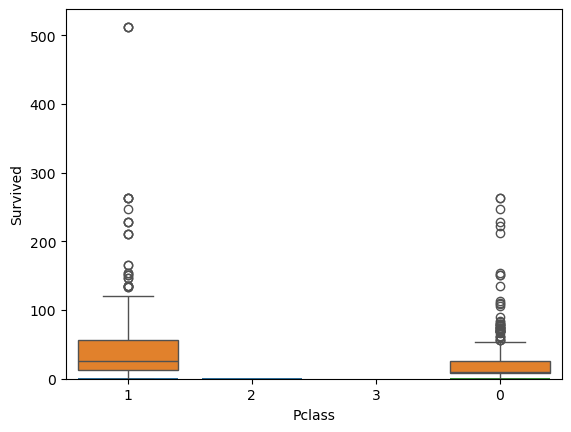